# Semantic Clustering Pipeline Demo

**End-to-end pipeline with semantic clustering for drift detection.**

This pipeline uses semantic clustering to group candidates by embedding similarity, then generates variations and tests for model drifts (positive and negative).

## Setup

In [1]:
import sys
import json
import pandas as pd
import matplotlib.pyplot as plt
import os

# API key
# For RITS: os.environ['RITS_API_KEY'] = 'your_api_key_here'

# Import from benchdrift package
from benchdrift.pipeline.unified_batched_pipeline_semantic import UnifiedBatchedPipeline

## Input Problems

You can either use hardcoded problems or load from a file:

In [2]:
# Option 1: Hardcoded problems (simple list)
problems = [
    # {
    #     "problem": "If it takes 30 minutes to walk to the store, and I leave at 2:00 PM, what time will I arrive?",
    #     "answer": "2:30 PM"
    # },
    # {
    #     "problem": "A meeting starts at 9:00 AM and lasts for 2 hours and 15 minutes. What time does it end?",
    #     "answer": "11:15 AM"
    # },
    # {
    #     "problem": "If I need to be at work by 8:00 AM and it takes 45 minutes to get ready plus 20 minutes to drive, what's the latest I can wake up?",
    #     "answer": "6:55 AM"
    # },
    # Long context problems for testing long context variations (>500 chars)
    {
        "problem": """RULES:
You are calculating total cost for a catering order.
Base price is $15 per person.
Groups of 20 or more get a 10% discount.
Weekend events have a $50 surcharge.
Delivery within 10 miles is free, beyond that costs $2 per mile.

EXAMPLES:
- 15 people, weekday, 5 miles: 15 × $15 = $225
- 25 people, weekend, 8 miles: (25 × $15 × 0.9) + $50 = $387.50
- 30 people, weekday, 15 miles: (30 × $15 × 0.9) + (5 × $2) = $415

QUESTION:
A company is ordering catering for 22 people for a Saturday event. The venue is 12 miles away. What is the total cost?""",
        "answer": "$351"
    },
#     {
#         "problem": """DB2 BACKUP UTILITIES REFERENCE

# The DB2 database system provides several backup utilities with different performance characteristics and use cases.

# BACKUP DATABASE Command Options:
# - ONLINE: Allows users to continue accessing the database during backup. Throughput: 50 GB/hour.
# - OFFLINE: Requires exclusive access, no user activity allowed. Throughput: 150 GB/hour.
# - INCREMENTAL: Backs up only changed data since last backup. Throughput: 100 GB/hour for changed data.

# Compression Options:
# - NO COMPRESSION: Backup size equals database size. No CPU overhead.
# - LIBRARY COMPRESSION: Reduces backup size by 60%. Adds 15 minutes per 100 GB processed.
# - NATIVE COMPRESSION: Reduces backup size by 40%. Adds 8 minutes per 100 GB processed.

# Example Scenarios:
# - 200 GB database, OFFLINE, NO COMPRESSION: Time = 200/150 = 1.33 hours = 80 minutes
# - 200 GB database, ONLINE, LIBRARY COMPRESSION: Time = (200/50) + (200/100 × 15) = 4 + 30 = 34 minutes... wait that's wrong. Time = (200/50) = 4 hours = 240 minutes, plus compression overhead = 240 + 30 = 270 minutes
# - 100 GB database, INCREMENTAL (20 GB changed), NATIVE COMPRESSION: Time = (20/100) + (100/100 × 8) = 0.2 hours = 12 minutes, plus compression = 12 + 8 = 20 minutes

# QUESTION:
# A production database of 300 GB needs to be backed up using OFFLINE mode with LIBRARY COMPRESSION. What is the total backup time in minutes?""",
#         "answer": "165 minutes"
#     },
    {
        "problem": """PROJECT COMPLETION TIME ANALYSIS

A software project has three phases that must be completed sequentially. Phase 1 requires 5 developers working for 3 weeks. Phase 2 requires 3 developers working for 4 weeks. Phase 3 requires 2 developers working for 2 weeks.

The company currently has 8 developers available. Developers cannot work on multiple phases simultaneously, but multiple developers can work on the same phase together.

Additional constraints: There is a mandatory 1-week review period between Phase 1 and Phase 2, and another 1-week review period between Phase 2 and Phase 3.

Given these constraints and the available workforce, what is the minimum total time in weeks needed to complete all three phases of the project?""",
        "answer": "10 weeks"
    }
]

# Save to file for pipeline (update path for new structure)
with open('../data/demo_problems.json', 'w') as f:
    json.dump(problems, f, indent=2)

# Option 2: Load from file (uncomment to use)
# with open('../data/temporal_test.json', 'r') as f:
#     problems = json.load(f)

print(f"📚 Loaded {len(problems)} problems:")
for i, p in enumerate(problems, 1):
    prob_text = p['problem']
    char_count = len(prob_text)
    label = "🔬 LONG CONTEXT" if char_count > 500 else ""
    print(f"   {i}. {prob_text[:60]}... ({char_count} chars) {label}")


📚 Loaded 2 problems:
   1. RULES:
You are calculating total cost for a catering order.
... (551 chars) 🔬 LONG CONTEXT
   2. PROJECT COMPLETION TIME ANALYSIS

A software project has thr... (733 chars) 🔬 LONG CONTEXT


In [3]:
# Semantic clustering pipeline configuration
config_semantic = {
    'unified_file': '../data/demo_output_semantic.json',
    'input_problems': '../data/demo_problems.json',
    'batch_size': 1,
    'max_workers': 1,
    
    # CLIENT & MODEL CONFIGURATION
    'client_type': 'rits',
    'model_name': 'phi-4',
    'judge_model': 'llama_3_3_70b',
    
    # Response model (target model - always uses RITS)
    'response_model': 'granite-3-3-8b',
    'response_client_type': 'rits',  # Target model client (always rits)
    
    'use_llm_judge': True,
    'rectify_invalid': True,
    
    # 🔧 MODEL PARAMETERS
    'max_model_len': 5000,  # Max context length (for VLLM only)
    'max_new_tokens': 1000,  # Max output tokens for generation
    
    # 🔬 SEMANTIC CLUSTERING (always enabled)
    'embedding_model': 'all-MiniLM-L6-v2',
    'semantic_threshold': 0.35,
    
    # 🧪 CAGrad dependencies (optional)
    'use_cagrad_dependencies': False,  # Set True to test cluster dependencies
    
    # 📋 Variation types
    'use_generic':False,  # Generic transformations (counterfactual, rephrasing, etc.)
    'use_cluster_variations': False,  # Cluster-based variations from semantic clusters
    'use_persona': False,  # Set True for persona variations (scientist, artist, chef, etc.)
    'use_long_context': True,  # Set True for prompts >500 chars (structure/positioning/quality)

    # Clean output (default)
    'verbose': False,  # or just omit this line
}


## Run Semantic Pipeline 🔬

**Variations** [Generates variations from input problems]-> **Validation** - Validates all variations (depends on: variations)-> **Responses** - Generates model responses (depends on: validation)

#### Variations taxonomy:
 - Persona (perspective variations)
 - Long-context (structure/formatting for long prompts)
 - Linguistic (linguistic/cognitive transformations)
 - Compositional (coordinated semantic transformations)

In [4]:
# Initialize pipeline
pipeline_semantic = UnifiedBatchedPipeline(config_semantic)

print("\n🚀 Running semantic pipeline...")
print("   Stage 1: Generating variations...")
pipeline_semantic.stage1_generate_variations_batched()

print("   Stage 2: Validating variations...")
pipeline_semantic.stage_validation()

print("   Stage 3: Generating responses...")
pipeline_semantic.stage2_generate_responses()

print(f"\n✅ Stages 1-3 complete! Ready for evaluation.")


🚀 Running semantic pipeline...
   Stage 1: Generating variations...


Processing batches: 100%|██████████| 2/2 [03:54<00:00, 117.17s/batch]
✅ Stage 1 complete: Generated 26 total entries across 2 batches


   Stage 2: Validating variations...


Validating variations:   0%|          | 0/1 [00:00<?, ?it/s]ERROR:root:RITS API call failed (attempt 1/3): HTTPSConnectionPool(host='inference-3scale-apicast-production.apps.rits.fmaas.res.ibm.com', port=443): Read timed out. (read timeout=60)
ERROR:root:RITS API call failed (attempt 1/3): HTTPSConnectionPool(host='inference-3scale-apicast-production.apps.rits.fmaas.res.ibm.com', port=443): Read timed out. (read timeout=60)
ERROR:root:RITS API call failed (attempt 1/3): HTTPSConnectionPool(host='inference-3scale-apicast-production.apps.rits.fmaas.res.ibm.com', port=443): Read timed out. (read timeout=60)
ERROR:root:RITS API call failed (attempt 1/3): HTTPSConnectionPool(host='inference-3scale-apicast-production.apps.rits.fmaas.res.ibm.com', port=443): Read timed out. (read timeout=60)
ERROR:root:RITS API call failed (attempt 2/3): HTTPSConnectionPool(host='inference-3scale-apicast-production.apps.rits.fmaas.res.ibm.com', port=443): Read timed out. (read timeout=60)
ERROR:root:RITS API 

   Stage 3: Generating responses...

✅ Stages 1-3 complete! Ready for evaluation.


## Evaluation - Evaluates drift (depends on: responses)

In [5]:
# Stage 4: Evaluation
# You can change the judge model/client here if needed
# For example, to use Gemini for evaluation:
# config_semantic['client_type'] = 'gemini'
# config_semantic['judge_model'] = 'gemini-3-pro-preview'

print("\n🚀 Stage 4: Evaluating results...")
pipeline_semantic.stage3_add_evaluation_metrics()

print(f"\n🎉 Semantic pipeline completed! Results saved to {config_semantic['unified_file']}")
print(f"   Total variations generated: {len([d for d in pipeline_semantic.data if d.get('is_variant', False)])}")


🚀 Stage 4: Evaluating results...


Evaluating: 100%|██████████| 3/3 [02:00<00:00, 40.06s/batch]
     📈 POSITIVE DRIFT: problem_0_variant_1
     📈 POSITIVE DRIFT: problem_0_variant_4
     📈 POSITIVE DRIFT: problem_0_variant_5
     📈 POSITIVE DRIFT: problem_0_variant_6
     📈 POSITIVE DRIFT: problem_0_variant_8
     📈 POSITIVE DRIFT: problem_0_variant_9
     📈 POSITIVE DRIFT: problem_0_variant_10
     📈 POSITIVE DRIFT: problem_0_variant_11
Evaluating:   0%|          | 0/4 [00:00<?, ?batch/s]ERROR:root:RITS API call failed (attempt 1/3): HTTPSConnectionPool(host='inference-3scale-apicast-production.apps.rits.fmaas.res.ibm.com', port=443): Read timed out. (read timeout=60)
ERROR:root:RITS API call failed (attempt 2/3): HTTPSConnectionPool(host='inference-3scale-apicast-production.apps.rits.fmaas.res.ibm.com', port=443): Read timed out. (read timeout=60)
Evaluating:  25%|██▌       | 1/4 [02:08<06:25, 128.54s/batch]ERROR:root:RITS API call failed (attempt 1/3): HTTPSConnectionPool(host='inference-3scale-apicast-production.app


🎉 Semantic pipeline completed! Results saved to ../data/demo_output_semantic.json
   Total variations generated: 24


## Results Analysis & Visualization

**Publication-quality comprehensive analysis with drift breakdown:**

You can analyze results from either basic or CAGrad mode (or compare both!):

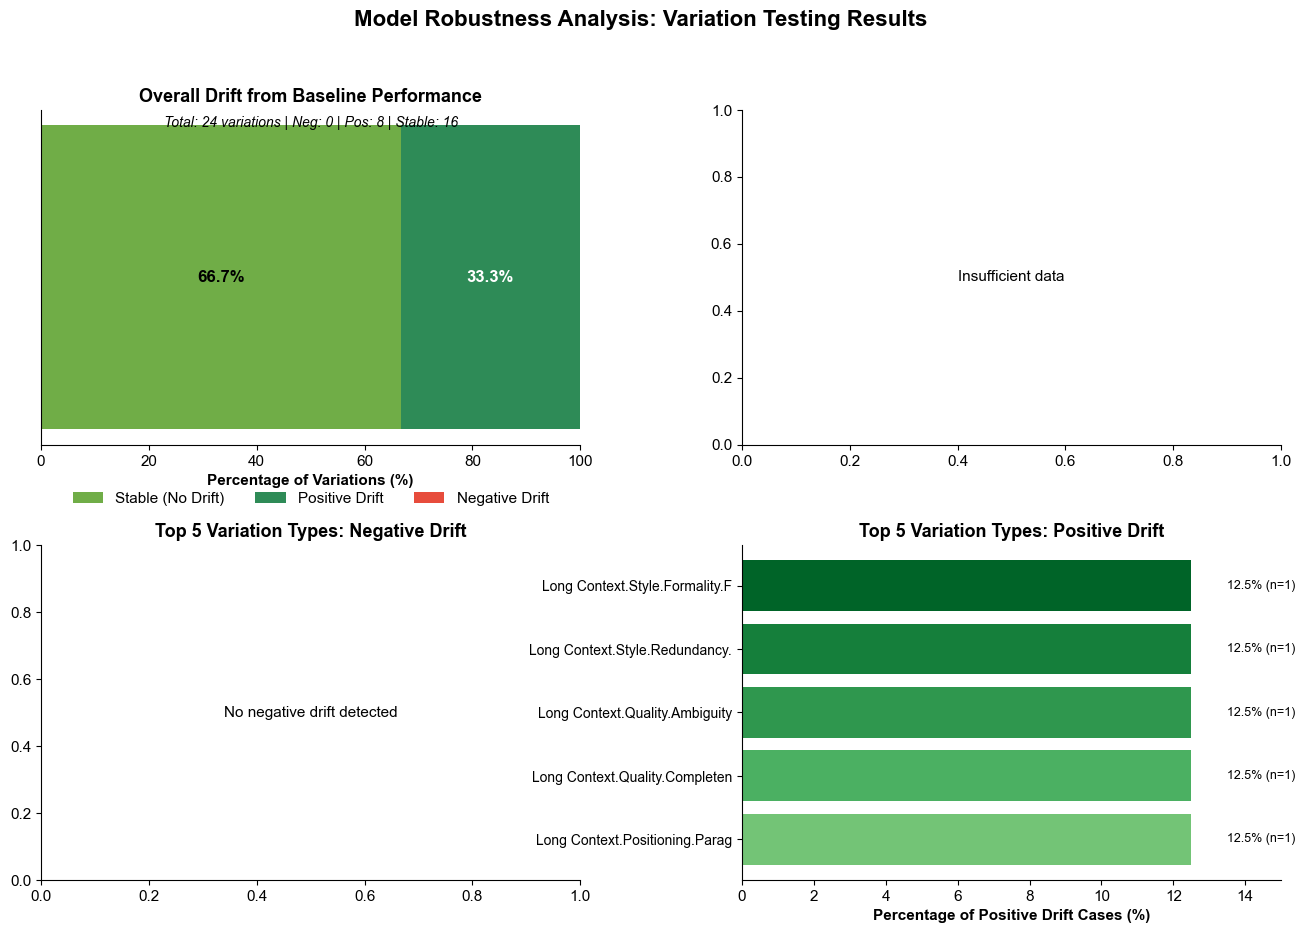


📊 COMPREHENSIVE ROBUSTNESS ANALYSIS SUMMARY

📋 Dataset Overview:
   • Total Problems: 2
   • Total Variations: 24
   • Variations per Problem: 12.0 avg

🎯 Overall Drift Analysis:
   • Stable (No Drift): 16 (66.7%)
   • Negative Drift: 0 (0.0%)
   • Positive Drift: 8 (33.3%)
   • Total Drift Rate: 33.3% 🔴 HIGH

⚠️  Top 5 Most Problematic Variation Types:

🟢 Positive Drift Breakdown (Top 5):
   1. Positioning Paragraphs Reverse: 1 cases (12.5% of pos. drift)
   2. Quality Completeness: 1 cases (12.5% of pos. drift)
   3. Quality Ambiguity: 1 cases (12.5% of pos. drift)
   4. Style Redundancy Remove: 1 cases (12.5% of pos. drift)
   5. Style Formality Formal: 1 cases (12.5% of pos. drift)

📂 Variation Category Analysis:

✅ Analysis Complete - Use visualizations above for publication/presentation


📋 CONCRETE DRIFT EXAMPLES

🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢
POSITIVE DRIFT EXAMPLES (Model Performance Improved)
🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢

──────────────────────────────

In [6]:
# Load results and create comprehensive visualizations
from benchdrift.eval.comprehensive_results_visualizer import visualize_results

df = pd.DataFrame(pipeline_semantic.data)

# viz = visualize_results(df, save_fig=True)
viz = visualize_results(df)

print(f"✅ Comprehensive analysis complete with {len(df)} total entries!")

In [7]:
# Optional: Sankey Flow Diagram (Alternative View)
# Shows transformation flow from problems through methods to capabilities
try:
    from benchdrift.pipeline.sankey_visualizer import Visualizer
    
    sankey_viz = Visualizer(df)
    sankey_viz.display_sankey(
        title="Transformation Flow: Methods → Debugging Capabilities",
        width=1200,
        height=700,
        top_debug_caps=10
    )
    print("🎯 Sankey diagram provides complementary flow visualization")
except ImportError:
    print("ℹ️  Sankey diagram requires plotly (optional)")
    print("   Main comprehensive analysis above is sufficient for publication")
except Exception as e:
    print(f"ℹ️  Sankey visualization skipped: {str(e)[:80]}")
    print("   Main comprehensive analysis above shows all key results")

Level 1 distribution:
  Generic: 0 variations
  Candidates: 24 variations
  Personas: 0 variations

Level 3 debugging capabilities found: 9
Selected top 10 debugging capabilities: ['order_robustness', 'formality_robustness', 'complexity_robustness', 'information_filtering', 'clarity_robustness', 'inference_robustness', 'coreference_robustness', 'redundancy_sensitivity', 'redundancy_dependency']



🎯 Enhanced Sankey shows: HOW variations are created → WHAT capabilities are tested
🎯 Sankey diagram provides complementary flow visualization


## Summary

**✅ Pipeline Complete!**

The comprehensive analysis above provides:
- **Panel 1**: Overall drift distribution (stable vs negative vs positive)
- **Panel 2**: Top 5 most problematic variation types
- **Panel 3**: Negative drift breakdown by variation type
- **Panel 4**: Positive drift breakdown by variation type
- **Text Summary**: Detailed statistics and quantitative analysis
- **Concrete Examples**: Top negative and positive drift cases with:
  - Original problem vs variation
  - Ground truth answer
  - Baseline answer (model's response to original)
  - Variant answer (model's response to variation)
  - Drift details showing performance change

Results are saved to `demo_output.json` for further analysis.

**Customization Options:**
```python
# Show examples (default)
viz = visualize_results(df, show_examples=True, top_n_examples=3)

# Skip examples (just visualizations)
viz = visualize_results(df, show_examples=False)
```